In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#drive.flush_and_unmount(timeout_ms=24)

In [3]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
Dataset_Name = "CIFAR_10"
base_dir = 'drive/My Drive/CIFAR10/CIFAR10_32p/'
work_dir = "drive/My Drive/CIFAR10/Records/"
#dataset_dir = "drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/MK/D2/"

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#data_instance = 64 # 64 256
color_type = 'rgb' # rgb, grayscale

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
BATCH_SIZE = 32

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb 
        class_mode='categorical',
        subset='training'
        ) 

Found 40000 images belonging to 10 classes.


In [8]:
num_classes = train_generator.num_classes
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 40000
train_generator.image_shape = (256, 256, 3)
num_classes = 10


In [9]:
val_generator = train_datagen.flow_from_directory(
        train_dir,
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle=False,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        subset='validation'
        )

Found 10000 images belonging to 10 classes.


In [10]:
total_val_data = val_generator.samples
print(f"total_val_data = {total_val_data}")

total_val_data = 10000


In [11]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle=False,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical')

Found 10000 images belonging to 10 classes.


In [12]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 10000


In [13]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "TransferLearning3D.DenseNet201" # TransferLearning3D 
dataset = f"{Dataset_Name}.{color_type}.{train_generator.image_shape[:2]}.TrainTestVal.DataFlow" # +str(img_size)+"p", .Original
dataset

'CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow'

In [14]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [15]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 10 # 300
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = ".Dense.1024.1024.2048" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f".Flatten.l2.{str(l2_val)}.run_2" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.hdf5
log_name = log.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.log


In [16]:
train_generator.image_shape

(256, 256, 3)

In [17]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
model.summary()
#'''

74842112/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_____________________________

In [18]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [19]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 715
Total number of layers = 715


In [20]:
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

'\ncheckpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"\nlog_name = "log."+checkpointer_name[8:-5]+".log"\n\nprint(\'checkpointer_name =\', checkpointer_name)\nprint(\'log_name =\', log_name)\n#'

In [21]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_accuracy',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_accuracy', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [23]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_acc > max_val_acc) and (abs(current_val_acc-max_val_acc) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased from",max_val_acc," to",current_val_acc,"( val_loss =",current_val_loss,").")

        elif (current_val_acc==max_val_acc) and (current_val_loss<min_val_loss):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased to", current_val_loss, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [24]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 10
checkpointer_name = weights.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.hdf5


In [25]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=val_generator,
                        validation_steps=total_val_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.hdf5
Previously completed epochs = 10
count_no_improvement = 0 


Time elapsed:  10.68264651298523


In [26]:
# 

In [27]:
'''
Record: CIFAR_10_impl_2_256p_RGB_Dense201_Custom_withImageNet_DataFlow: (90.61%)
;
---

#'''

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[0],4), epochs_completed, checkpointer_name))


  1/312 [..............................] - ETA: 54:32 - loss: 2.6490 - accuracy: 0.9688

KeyboardInterrupt: ignored

In [28]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded drive/My Drive/CIFAR10/Records/best_weights.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.hdf5.


In [29]:
'''
Record: CIFAR_10_impl_2_256p_RGB_Dense201_Custom_withImageNet_DataFlow: (90.61%)
;
---
Test Acc: 0.9544, Test Loss: 3.3165: ep10, best_weights.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.hdf5

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


312/312 [==============================] - 3058s 10s/step - loss: 3.3165 - accuracy: 0.9544
Test Acc: 0.9544, Test Loss: 3.3165: ep10, best_weights.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.hdf5



In [30]:
import csv 

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [31]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


313/313 [==============================] - 1966s 6s/step
Saved: drive/My Drive/CIFAR10/Records/Y_pred.CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2


In [32]:
'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

'\nsave_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"\nnp.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)\nprint(f"Saved: {work_dir}{save_predictions_filename}")\n#'

In [33]:
#Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename_2}.npy", allow_pickle=True)
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (10000, 10)


In [34]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [35]:
y_true = test_generator.classes

In [36]:
list_class_names_in_generator = list(test_generator.class_indices.values())
list_class_names_in_generator[:5]

[0, 1, 2, 3, 4]

In [37]:
len(list_class_names_in_generator)

10

In [38]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    #print(f"true_class = {true_class}; pred_class = {pred_class}")
    #y_true_rearranged = int(list_class_names_in_generator[true_class][5:])
    #y_pred_rearranged = int(list_class_names_in_generator[pred_class][5:])

    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [39]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
print(f"np_y_true_rearranged: {np_y_true_rearranged}")
print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (10000,)
np_y_pred_rearranged.shape = (10000,)
np_y_true_rearranged: [0 0 0 ... 9 9 9]
np_y_pred_rearranged: [0 0 0 ... 9 9 9]


In [40]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (10000,)

y_true[-5:] = [9 9 9 9 9]
y_pred[-5:] = [9 9 9 9 9]

np_y_true_rearranged[-5:] = [9 9 9 9 9]
np_y_pred_rearranged[-5:] = [9 9 9 9 9]

np.unique(np_y_true_rearranged) = [0 1 2 3 4 5 6 7 8 9]
np.unique(np_y_pred_rearranged) = [0 1 2 3 4 5 6 7 8 9]


In [41]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[964   6   0   1   0   0   0   1   9  19]
 [  4 979   0   2   2   0   1   0  12   0]
 [  0   0 980   3   4   1   4   7   1   0]
 [  1   3  18 869  12  68  16   7   5   1]
 [  1   0  14  12 950   6   5   1  11   0]
 [  0   0  11  35  11 935   1   7   0   0]
 [  0   1   4   6   5   1 980   1   2   0]
 [  0   0  12   7   8  12   1 958   2   0]
 [  2  17   7   4   6   0   0   2 960   2]
 [ 17   8   0   0   0   0   0   1   4 970]]


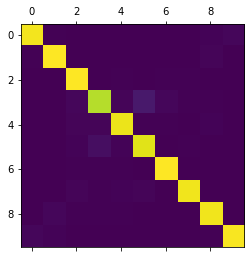

In [42]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [43]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = drive/My Drive/CIFAR10/Records/Images/conf_matrix_CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.png


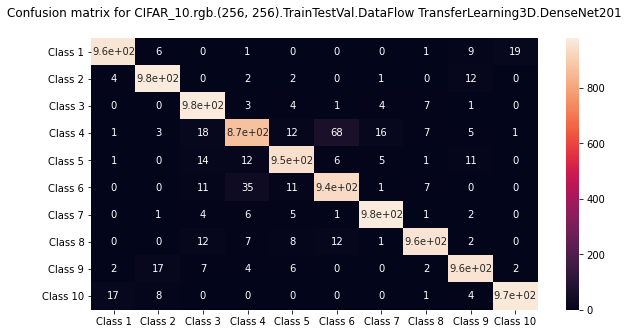

In [44]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (10,5))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'Images/conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [45]:
#Confution Matrix and Classification Report
'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(np_test_label, y_pred))
#'''

"\nY_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))\ny_pred = np.argmax(Y_pred, axis=1)\nprint('Confusion Matrix')\nprint(sklearn.metrics.confusion_matrix(np_test_label, y_pred))\n#"

In [46]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
'''
print('Classification Report:')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred))
#'''

"\nprint('Classification Report:')\nprint(sklearn.metrics.classification_report(test_generator.classes, y_pred))\n#"

In [47]:
test_generator.class_indices.keys()

dict_keys(['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt-top', 'Trouser'])

In [48]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(np_y_true_rearranged, np_y_pred_rearranged, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

  Ankle boot       0.97      0.96      0.97      1000
         Bag       0.97      0.98      0.97      1000
        Coat       0.94      0.98      0.96      1000
       Dress       0.93      0.87      0.90      1000
    Pullover       0.95      0.95      0.95      1000
      Sandal       0.91      0.94      0.92      1000
       Shirt       0.97      0.98      0.98      1000
     Sneaker       0.97      0.96      0.97      1000
 T-shirt-top       0.95      0.96      0.96      1000
     Trouser       0.98      0.97      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [49]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [50]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.645725,5.435403,0.897135,4.456844
1,1,0.878750,4.357491,0.931891,4.054291
2,2,0.925650,3.918433,0.942007,3.791095
3,3,0.954800,3.607637,0.947716,3.597122
4,4,0.969075,3.387542,0.948918,3.446046


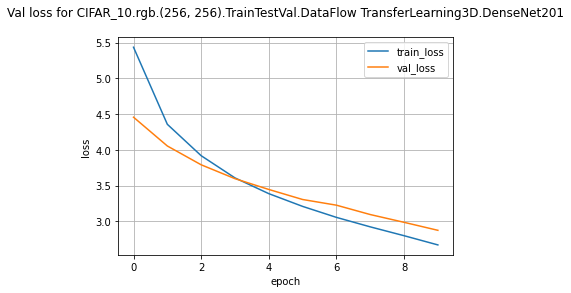

img_path = drive/My Drive/CIFAR10/Records/Images/vLoss_CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.png


In [51]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

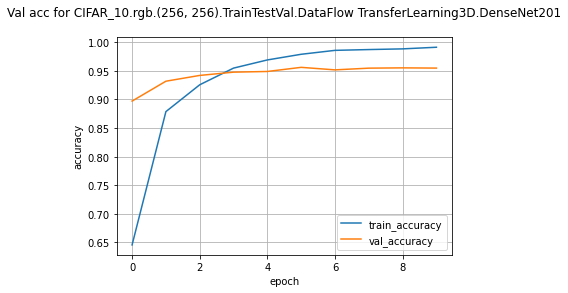

img_path = drive/My Drive/CIFAR10/Records/Images/vAcc_CIFAR_10.rgb.(256, 256).TrainTestVal.DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_2.png


In [52]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)